In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import wave, struct
from copy import deepcopy
from weighted_levenshtein import lev

from scipy.io import wavfile


from Classifier.load_data import load_training_data

from Classifier.plot_data import plot_labelled_wave, plot_predictions, plot_detection_errors

from Classifier.classifier import (streaming_classifier,
                                   three_pronged_smoothing_classifier,
                                   two_pronged_smoothing_classifier,
                                   one_pronged_smoothing_classifier,
                                   zeroes_classifier,
                                   catch22_knn_classifier)


In [2]:
waves, labels, samprate = load_training_data(path = "Datasets/",
                                             scale_factor= 1,
                                             blacklist = ["data0"],
                                             whitelist = ["data"])

samprate = 10_000


time_buffers = {"data3":(-0.3, 0.55),
                "data2":(-0.3, 0.55),
                "data0":(-0.3, 0.55),
                "data1":(-0.3, 0.55),
                "data5":(-0.5, 0.75),
                "data4":(-0.5, 0.75)}


dict_keys(['data3', 'data2', 'data1', 'data5', 'data4']) dict_keys(['data1', 'data3', 'data2', 'data5', 'data4'])


/Users/billydodds/Documents/Uni/DATA3888/Aqua10/Classifier/load_data.py:72: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)


In [3]:
def my_lev_dist(prediction, actual, L_cost = 1.25, R_cost = 1.25, under_score_cost = 0.5):
    substitute_costs = np.ones((128, 128), dtype=np.float64)  
    substitute_costs[ord('L'), ord('R')] = L_cost
    substitute_costs[ord('R'), ord('L')] = R_cost
    substitute_costs[ord('_'), ord('L')] = under_score_cost
    substitute_costs[ord('_'), ord('R')] = under_score_cost
    return lev(prediction, actual, substitute_costs = substitute_costs)



def ts_zero_crossings(x):
    return np.sum(x[0:-1]*x[1::] <= 0)


In [4]:
# Set parameters such that event detection window lands in the middle of the signal

hyp_event_smart_threshold_window = 5
hyp_event_smart_threshold_factor = 0.26

hyp_detection_buffer_end = 1/samprate
hyp_detection_buffer_start = 0


det_window = 0.45

window_size = det_window + hyp_detection_buffer_end + hyp_detection_buffer_start

N_loops_over_window = int(np.ceil(window_size/0.05))

# hyp_consecutive_triggers = int(np.ceil(det_window/buffer_size))
# print(hyp_consecutive_triggers)




# fig, ax = plt.subplots(len(waves), 1)
# fig.set_size_inches(15, 3*len(waves))



classifiers = {"One-pronged": one_pronged_smoothing_classifier,
               "Two-pronged": two_pronged_smoothing_classifier,
               "Three-pronged": three_pronged_smoothing_classifier,
               "Zeros classifier": zeroes_classifier,
               "KNN classifier": catch22_knn_classifier}

open("classifier_optimisation.csv", 'w').close()    # Clears the file so that the code can be run again.

for classifier_label, classifier in classifiers.items():
    print(classifier_label)
    for w in np.linspace(0, 2-det_window, 200):
        hyp_detection_buffer_end = max(w/2, 1/samprate)
        hyp_detection_buffer_start = w/2
        window_size = det_window + hyp_detection_buffer_end + hyp_detection_buffer_start
        
        buffer_size = 0.05
        N_loops_over_window = int(np.ceil(window_size/buffer_size))


#         hyp_consecutive_triggers = int(np.ceil(det_window/buffer_size))



        for i, key in enumerate(waves):
            
            predictions, predictions_timestamps, predictions_storage = streaming_classifier(
                waves[key],
                samprate,
                classifier = classifier,
                window_size = window_size, # time plotted in window [s]
                N_loops_over_window = N_loops_over_window, # implicitly defines buffer to be 1/x of the window
                total_time = None,  # max time
                hyp_detection_buffer_end = hyp_detection_buffer_end, # seconds - how much time to shave off either end of the window in order to define the middle portion
                hyp_detection_buffer_start = hyp_detection_buffer_start,
                hyp_event_smart_threshold_window = hyp_event_smart_threshold_window, 
                hyp_event_smart_threshold_factor = hyp_event_smart_threshold_factor, 
                hyp_calibration_statistic_function = lambda x: ts_zero_crossings(x)/(len(x)/samprate)*det_window, # Function that calculates the calibration statistic
                hyp_test_statistic_function = ts_zero_crossings, # Function that calculates the test statistic
                hyp_event_history = 30,
    #             hyp_timeout = 20,
                hyp_consecutive_triggers = 2,
                hyp_consecutive_reset = 10,
#                 zeroes_consec_threshold = 0.1, 
#                 using_zeroes_classifier = key == "Zeros classifier",
                plot = False,
                store_events = True, 
                verbose=False,
                live = False,
    #             dumb_threshold = True,
                flip_threshold = True
    #             timeout = True
        )

            actuals = "".join(labels[key].label)

            lev_dist = my_lev_dist(predictions, actuals)
            acc = max((len(actuals) - lev_dist), 0)/len(actuals)
                        
            with open("classifier_optimisation.csv", "a") as file:
                file.write(",".join([classifier_label, str(window_size), key, predictions, actuals, str(lev_dist), str(acc)]) + '\n')


    
    
#     plot_predictions(waves[key], samprate, labels[key], predictions, predictions_timestamps, ax, i,
#                      title="", before_buffer = 0.7, after_buffer = 1, actual_alpha=0.0,
#                      wave_alpha=1, pred_alpha = 0.5, miny = -100, maxy = 100)



One-pronged
Two-pronged
Three-pronged
Zeros classifier
KNN classifier


In [5]:
results = pd.read_csv("classifier_optimisation.csv", header=None)

results.columns = ["classifier", "window_size", "file", "predicted", "actual", "lev_dist", "accuracy"]

results_agg = results.groupby(["window_size", "classifier"]).mean()
results_agg.reset_index(inplace=True)
results_agg

,window_size,classifier,lev_dist,accuracy
0,0.4501,KNN classifier,6.35,0.672964
1,0.4501,One-pronged,1.80,0.892271
2,0.4501,Three-pronged,9.30,0.459804
3,0.4501,Two-pronged,9.30,0.459804
4,0.4501,Zeros classifier,1.50,0.908892
...,...,...,...,...
995,2.0000,KNN classifier,7.25,0.570550
996,2.0000,One-pronged,3.30,0.792745
997,2.0000,Three-pronged,10.05,0.384081
998,2.0000,Two-pronged,7.30,0.542165


Text(0.5, 1.0, 'Classifier Accuracy vs. Window Size')

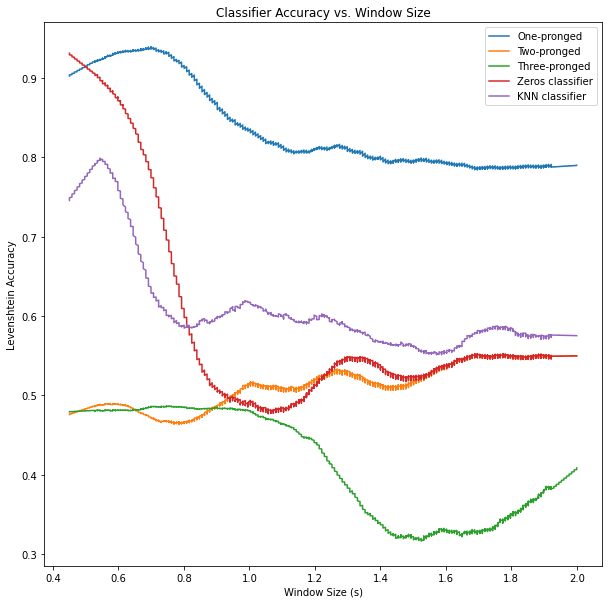

In [27]:
from scipy import signal


plt.figure(figsize=(10, 10))

for classifier in results.classifier.unique():
    filt = results.classifier == classifier
    plt.plot(results[filt].window_size, signal.savgol_filter(results[filt].accuracy, 101, 1), label=classifier)

plt.legend()
plt.ylabel("Levenshtein Accuracy")
plt.xlabel("Window Size (s)")
plt.title("Classifier Accuracy vs. Window Size")


0.6836683417085427 0.9388235294117646


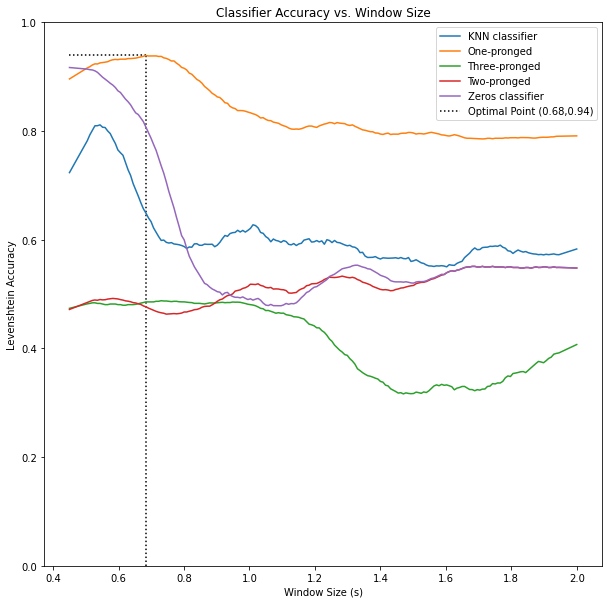

In [57]:



plt.figure(figsize=(10, 10))

for classifier in results_agg.classifier.unique():
    filt = results_agg.classifier == classifier
    plt.plot(results_agg[filt].window_size, signal.savgol_filter(results_agg[filt].accuracy, 15, 1), label=classifier)

plt.ylabel("Levenshtein Accuracy")
plt.xlabel("Window Size (s)")
plt.title("Classifier Accuracy vs. Window Size")
plt.ylim(0, 1)


filt = results_agg.classifier == "One-pronged"
max_arg = np.argmax(signal.savgol_filter(results_agg[filt].accuracy, 15, 1))
max_val = np.max(signal.savgol_filter(results_agg[filt].accuracy, 15, 1))

optimal_window = np.array(results_agg[filt].window_size)[max_arg]

plt.vlines(optimal_window, 0, max_val, linestyle=":", label=f"Optimal Point ({round(optimal_window, 2)},{round(max_val, 2)})")
plt.hlines(max_val, 0.45, optimal_window, linestyle=":")

plt.legend()


print(optimal_window, max_val)



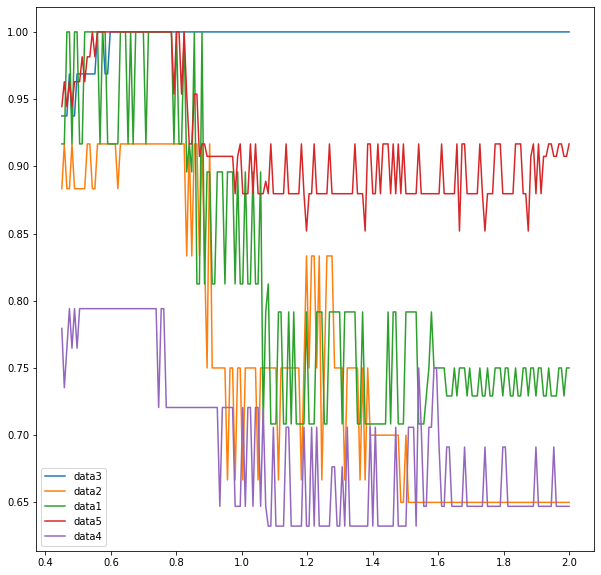

In [56]:
"One-pronged"


plt.figure(figsize=(10, 10))
for file in results.file.unique():
    filt = (results.classifier == "One-pronged") & (results.file == file)
    plt.plot(results[filt].window_size,
             results[filt].accuracy, label = file)
    
plt.legend()

In [12]:
prong = results_agg[results_agg.classifier == "One-pronged"]



In [16]:
prong.window_size[signal.savgol_filter(prong.accuracy, 15, 1) == np.max(signal.savgol_filter(prong.accuracy, 15, 1))]





151    0.683668
Name: window_size, dtype: float64

In [58]:
window_size = 0.6836


det_window = 0.45


hyp_detection_buffer_end = (window_size - det_window)/2

hyp_detection_buffer_start = (window_size - det_window)/2


predictions, predictions_timestamps, predictions_storage = streaming_classifier(
                waves[key],
                samprate,
                classifier = one_pronged_smoothing_classifier,
                window_size = window_size, # time plotted in window [s]
                N_loops_over_window = N_loops_over_window, # implicitly defines buffer to be 1/x of the window
                total_time = None,  # max time
                hyp_detection_buffer_end = hyp_detection_buffer_end, # seconds - how much time to shave off either end of the window in order to define the middle portion
                hyp_detection_buffer_start = hyp_detection_buffer_start,
                hyp_event_smart_threshold_window = hyp_event_smart_threshold_window, 
                hyp_event_smart_threshold_factor = hyp_event_smart_threshold_factor, 
                hyp_calibration_statistic_function = lambda x: ts_zero_crossings(x)/(len(x)/samprate)*det_window, # Function that calculates the calibration statistic
                hyp_test_statistic_function = ts_zero_crossings, # Function that calculates the test statistic
                hyp_event_history = 30,
    #             hyp_timeout = 20,
                hyp_consecutive_triggers = 2,
                hyp_consecutive_reset = 10,
#                 zeroes_consec_threshold = 0.1, 
#                 using_zeroes_classifier = key == "Zeros classifier",
                plot = False,
                store_events = True, 
                verbose=False,
                live = False,
    #             dumb_threshold = True,
                flip_threshold = True
    #             timeout = True
        )

In [59]:
predictions

'LRRLLRLRLRLRLRRLLRL'